In [1]:
# https://developers.tokenmetrics.com/docs/3-backtesting-and-analysis

In [2]:
import pandas as pd
import backtrader as bt
import numpy as np
import pyfolio as pf

import csv
import pytz

/home/quincy/miniconda3/envs/finance/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
with pd.HDFStore('./large_files/data2.h5', mode='r') as store:
    df = store.get('data/data_imputed_20240217')
df.info(verbose=3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2518127 entries, 525 to 116265
Data columns (total 10 columns):
 #   Column    Dtype                           
---  ------    -----                           
 0   date      object                          
 1   time      object                          
 2   open      float64                         
 3   high      float64                         
 4   low       float64                         
 5   close     float64                         
 6   volume    int64                           
 7   datetime  datetime64[ns, America/New_York]
 8   day       object                          
 9   month     int64                           
dtypes: datetime64[ns, America/New_York](1), float64(4), int64(2), object(3)
memory usage: 211.3+ MB


In [4]:
df = df.set_index('datetime', drop=False)
df = df.loc[df.index.year.isin([2021, 2022])]
df = df.loc[df.index.day_of_week == 2]

# Mean Reversion Strategy
1. Enter when current price is less than -1.0 std relative to sma.
1. Exit when current price is more than 1.0 std relative to sma  

*If a simple MA based strategy works decently, it suggests that trend trading is suitable*

In [5]:
# csv_file = open('outputs/mean_reversion00.csv', 'w', newline='')
# csv_writer = csv.writer(csv_file)
# csv_writer.writerow(['Date', 'Action', 'Price'])

class MeanReversionStrategy(bt.Strategy):
    params = (
        ('period', 15),  # Period for the moving average
        ('devfactor', 1.0),  # Factor for z-score threshold
        ('csv_writer', None)
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period)
        self.std = bt.indicators.StandardDeviation(self.datas[0], period=self.params.period)
        self.z_score = (self.dataclose - self.sma) / self.std

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.datetime(0)
        cash = self.broker.get_cash()
        value = self.broker.get_value()
        shares = self.position.size
        print('%s, %s, Cash: %.2f, Portfolio Value: %.2f, Shares Owned: %d' % (dt.isoformat(), txt, cash, value, shares))

    def next(self):
        past_close = []
        for i in range(1, self.params.period):
            past_close.append(self.datas[0].close[-i])
        high = np.max(past_close)
        low = np.min(past_close)

        if self.z_score[0] > 0 and self.position:
            self.log('Short at %.2f' % self.dataclose[0])
            self.sell()

        elif self.z_score[0] < -self.params.devfactor:
            self.log('Long at %.2f' % self.dataclose[0])
            self.buy()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('Buy executed at %.2f' % order.executed.price)
                if self.params.csv_writer is not None:
                    self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Buy', order.executed.price])
            elif order.issell():
                self.log('Sell executed at %.2f' % order.executed.price)
                if self.params.csv_writer is not None:
                    self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Sell', order.executed.price])

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    def stop(self):
        if self.position:
            self.log('Closing position')
            self.close()
            if self.params.csv_writer is not None:
                self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Sell', self.dataclose[0]])

In [6]:
df_result = []

csv_file = open('outputs/mean_reversion00.csv', 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Date', 'Action', 'Price'])

for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
    if df_day.shape[0] == 0:
        continue
    
    df_day = df_day.copy()
    df_day = df_day[(df_day.index.hour >= 10) & (df_day.index.hour < 12)]
    data = bt.feeds.PandasData(dataname=df_day)
    
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(100000.0)
    cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
    cerebro.adddata(data)
    cerebro.addstrategy(MeanReversionStrategy, devfactor=1.0, csv_writer=csv_writer)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    bt_results = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('\n\n')

    strat = bt_results[0]

    pnl = cerebro.broker.getvalue() - cerebro.broker.startingcash

    df_result.append({
        'datetime': day,
        'portfolio': cerebro.broker.getvalue(),
        'pnl': pnl,
        # 'sharpe_ratio': sharpe_ratio
    })
csv_file.close()
df_result = pd.DataFrame(df_result)

Starting Portfolio Value: 100000.00
2021-01-06T15:15:00, Long at 49.91, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:16:00, Buy executed at 49.91, Cash: 0.00, Portfolio Value: 100060.11, Shares Owned: 2003
2021-01-06T15:17:00, Long at 49.85, Cash: 0.00, Portfolio Value: 99879.78, Shares Owned: 2003
2021-01-06T15:18:00, Order Canceled/Margin/Rejected, Cash: 0.00, Portfolio Value: 99939.89, Shares Owned: 2003
2021-01-06T15:18:00, Long at 49.88, Cash: 0.00, Portfolio Value: 99939.89, Shares Owned: 2003
2021-01-06T15:19:00, Order Canceled/Margin/Rejected, Cash: 0.00, Portfolio Value: 100020.04, Shares Owned: 2003
2021-01-06T15:20:00, Short at 49.97, Cash: 0.00, Portfolio Value: 100120.22, Shares Owned: 2003
2021-01-06T15:21:00, Sell executed at 49.97, Cash: 100120.22, Portfolio Value: 100120.22, Shares Owned: 0
2021-01-06T15:21:00, OPERATION PROFIT, GROSS 120.22, NET 120.22, Cash: 100120.22, Portfolio Value: 100120.22, Shares Owned: 0
2021-01-06T15:24:00, Long

<Axes: xlabel='datetime'>

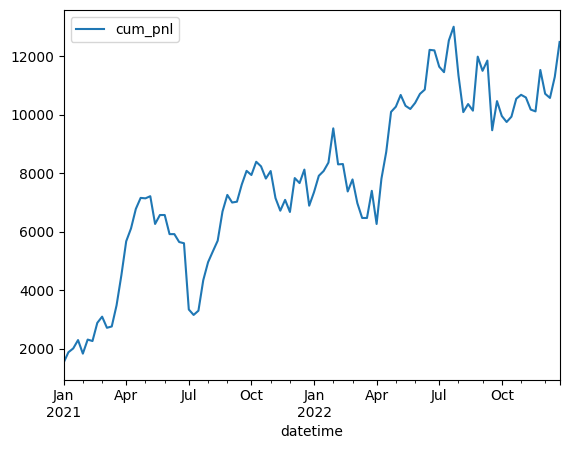

In [7]:
df_trades = pd.read_csv('./outputs/mean_reversion00.csv')
df_trades['Date'] = pd.to_datetime(df_trades['Date'])
timezone = pytz.timezone('Etc/GMT+6')
sharpes = []
for day, df_day in df_trades.groupby(pd.Grouper(key='Date', freq='D')):
    if df_day.shape[0] == 0:
        continue
    df_day = df_day.copy()
    df_buy = df_day[df_day['Action'] == 'Buy']
    df_sell = df_day[df_day['Action'] == 'Sell']
    returns = df_sell['Price'].to_numpy() - df_buy['Price'].to_numpy()

    n_winning_trades = (returns > 0).astype(int).sum()
    n_losing_trades = len(returns) - n_winning_trades
    
    sharpe_ratio = np.mean(returns) / max(0.001, np.std(returns))
    sharpes.append({
        'datetime': day.tz_localize('US/Eastern'), 
        'n_trades': len(returns),
        'n_winning_trades': n_winning_trades,
        'n_losing_trades': n_losing_trades,
        'sharpe_ratio': sharpe_ratio,
    })

sharpes = pd.DataFrame(sharpes)
df_result = pd.merge(df_result, sharpes, how='left', on='datetime')
df_result['cum_pnl'] = df_result['pnl'].cumsum()
df_result.plot(x='datetime', y='cum_pnl')

# July losing money?

In [8]:
print(
    f'Average: {df_result["pnl"].mean():.2f}  Sharpe Ratio: {df_result["sharpe_ratio"].mean():.2f}\n' \
    f'Wins: {(df_result["pnl"] > 0).sum()}  Avg: {df_result.loc[df_result["pnl"] > 0, "pnl"].mean():.2f}\n' \
    f'Losses: {(df_result["pnl"] < 0).sum()}  Avg: {df_result.loc[df_result["pnl"] < 0, "pnl"].mean():.2f}\n'
)

Average: 120.14  Sharpe Ratio: 1.89
Wins: 62  Avg: 581.27
Losses: 42  Avg: -560.58



# SMA Crossover Strategy

In [9]:
class SMACrossoverStrategy(bt.Strategy):
    params = (
        ('sma_period_short', 20),
        ('sma_period_long', 50),
        ('csv_writer', None)
    )

    def __init__(self):
        self.sma_short = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.sma_period_short)
        self.sma_long = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.sma_period_long)
        self.crossover = bt.indicators.CrossOver(self.sma_short, self.sma_long)
        self.dataclose = self.datas[0].close

    def next(self):
        if self.position.size == 0:  # If not in the market
            if self.crossover > 0:   # If short SMA crosses above long SMA
                self.log('Long at %.2f' % self.dataclose[0])
                self.buy()

        elif self.position.size > 0:  # If in a long position
            if self.crossover < 0:    # If short SMA crosses below long SMA
                self.log('Short at %.2f' % self.dataclose[0])
                self.sell()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('Buy executed at %.2f' % order.executed.price)
                if self.params.csv_writer is not None:
                    self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Buy', order.executed.price])
            elif order.issell():
                self.log('Sell executed at %.2f' % order.executed.price)
                if self.params.csv_writer is not None:
                    self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Sell', order.executed.price])

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    def stop(self):
        if self.position:
            self.log('Closing position')
            self.close()
            if self.params.csv_writer is not None:
                self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Sell', self.dataclose[0]])

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.datetime(0)
        cash = self.broker.get_cash()
        value = self.broker.get_value()
        shares = self.position.size
        print('%s, %s, Cash: %.2f, Portfolio Value: %.2f, Shares Owned: %d' % (dt.isoformat(), txt, cash, value, shares))

In [10]:
df_result = []

csv_file = open('outputs/smaxover00.csv', 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Date', 'Action', 'Price'])

for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
    if df_day.shape[0] == 0:
        continue
    
    df_day = df_day.copy()
    df_day = df_day[(df_day.index.hour >= 9) & (df_day.index.hour < 12)]
    data = bt.feeds.PandasData(dataname=df_day)
    
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(100000.0)
    cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
    cerebro.adddata(data)
    cerebro.addstrategy(SMACrossoverStrategy, sma_period_short=20, sma_period_long=50, csv_writer=csv_writer)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    bt_results = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('\n\n')

    strat = bt_results[0]

    pnl = cerebro.broker.getvalue() - cerebro.broker.startingcash

    df_result.append({
        'datetime': day,
        'portfolio': cerebro.broker.getvalue(),
        'pnl': pnl
    })
csv_file.close()
df_result = pd.DataFrame(df_result)

Starting Portfolio Value: 100000.00
2021-01-06T15:34:00, Long at 50.30, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:35:00, Buy executed at 50.30, Cash: 0.00, Portfolio Value: 100039.76, Shares Owned: 1988
2021-01-06T16:59:00, Closing position, Cash: 0.00, Portfolio Value: 101013.92, Shares Owned: 1988
Final Portfolio Value: 101013.92



Starting Portfolio Value: 100000.00
2021-01-13T15:07:00, Long at 52.97, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-13T15:08:00, Buy executed at 52.96, Cash: 18.88, Portfolio Value: 100018.88, Shares Owned: 1887
2021-01-13T16:14:00, Short at 53.06, Cash: 18.88, Portfolio Value: 100188.79, Shares Owned: 1887
2021-01-13T16:15:00, Sell executed at 53.05, Cash: 100169.91, Portfolio Value: 100169.91, Shares Owned: 0
2021-01-13T16:15:00, OPERATION PROFIT, GROSS 169.91, NET 169.91, Cash: 100169.91, Portfolio Value: 100169.91, Shares Owned: 0
Final Portfolio Value: 100169.91



Starting Portfolio Value: 10

<Axes: title={'center': '5850.569540688433'}, xlabel='datetime'>

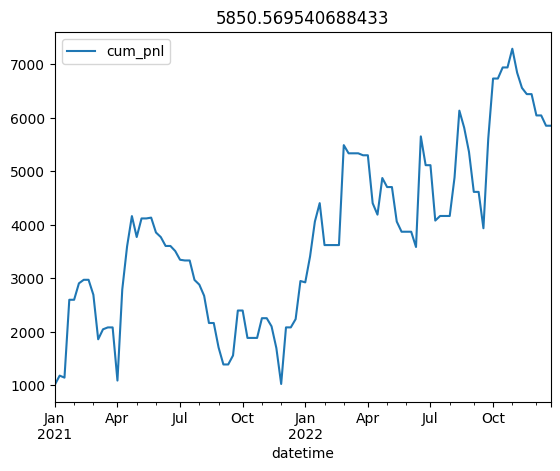

In [11]:
df_trades = pd.read_csv('./outputs/smaxover00.csv')
df_trades['Date'] = pd.to_datetime(df_trades['Date'])
timezone = pytz.timezone('Etc/GMT+6')
sharpes = []
for day, df_day in df_trades.groupby(pd.Grouper(key='Date', freq='D')):
    if df_day.shape[0] == 0:
        continue
    df_day = df_day.copy()
    df_buy = df_day[df_day['Action'] == 'Buy']
    df_sell = df_day[df_day['Action'] == 'Sell']
    returns = df_sell['Price'].to_numpy() - df_buy['Price'].to_numpy()

    n_winning_trades = (returns > 0).astype(int).sum()
    n_losing_trades = len(returns) - n_winning_trades
    
    sharpe_ratio = np.mean(returns) / max(0.001, np.std(returns))
    sharpes.append({
        'datetime': day.tz_localize('US/Eastern'), 
        'n_trades': len(returns),
        'n_winning_trades': n_winning_trades,
        'n_losing_trades': n_losing_trades,
        'sharpe_ratio': sharpe_ratio,
    })

sharpes = pd.DataFrame(sharpes)
df_result = pd.merge(df_result, sharpes, how='left', on='datetime')
df_result['cum_pnl'] = df_result['pnl'].cumsum()
df_result.plot(x='datetime', y='cum_pnl', title=df_result['cum_pnl'].tolist()[-1])

In [12]:
print(
    f'Average: {df_result["pnl"].mean():.2f}  Sharpe Ratio: {df_result["sharpe_ratio"].mean():.2f}\n' \
    f'Wins: {(df_result["pnl"] > 0).sum()}  Avg: {df_result.loc[df_result["pnl"] > 0, "pnl"].mean():.2f}\n' \
    f'Losses: {(df_result["pnl"] < 0).sum()}  Avg: {df_result.loc[df_result["pnl"] < 0, "pnl"].mean():.2f}\n'
)

Average: 56.26  Sharpe Ratio: 46.49
Wins: 31  Avg: 692.45
Losses: 42  Avg: -371.80



# SMA Breakout Strategy
1. Long when price breakouts of SMA for certain percentage

In [15]:
class SMABreakoutStrategy(bt.Strategy):
    params = (
        ('sma_period', 50),
        ('breakout_buffer', 0.01),  # Buffer percentage for breakout
        ('csv_writer', None),
    )

    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.sma_period)
        self.breakout_buffer = self.params.breakout_buffer
        self.dataclose = self.datas[0].close

    def next(self):
        if self.position.size == 0:  # If not in the market
            if self.data.close[0] > self.sma[0] * (1 + self.breakout_buffer):  # If price breaks above SMA
                self.log('Long at %.2f' % self.dataclose[0])
                self.buy()

        elif self.position.size > 0:  # If in a long position
            if self.data.close[0] < self.sma[0]:  # If price crosses below SMA
                self.log('Short at %.2f' % self.dataclose[0])
                self.sell()
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('Buy executed at %.2f' % order.executed.price)
                if self.params.csv_writer is not None:
                    self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Buy', order.executed.price])
            elif order.issell():
                self.log('Sell executed at %.2f' % order.executed.price)
                if self.params.csv_writer is not None:
                    self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Sell', order.executed.price])

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            if order.status == order.Canceled:
                self.log('Order Canceled')
            elif order.status == order.Margin:
                self.log('Order Margin')
            else:
                self.log('Order Rejected')

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    def stop(self):
        if self.position:
            self.log('Closing position')
            self.close()
            if self.params.csv_writer is not None:
                self.params.csv_writer.writerow([self.datas[0].datetime.datetime(0).isoformat(), 'Sell', self.dataclose[0]])

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.datetime(0)
        cash = self.broker.get_cash()
        value = self.broker.get_value()
        shares = self.position.size
        print('%s, %s, Cash: %.2f, Portfolio Value: %.2f, Shares Owned: %d' % (dt.isoformat(), txt, cash, value, shares))

In [25]:
df_result = []

csv_file = open('outputs/smabreakout00.csv', 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Date', 'Action', 'Price'])

for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
    if df_day.shape[0] == 0:
        continue
    
    df_day = df_day.copy()
    df_day = df_day[(df_day.index.hour >= 9) & (df_day.index.hour < 12)]
    data = bt.feeds.PandasData(dataname=df_day)
    
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(100000.0)
    cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
    cerebro.adddata(data)
    cerebro.addstrategy(SMABreakoutStrategy, sma_period=15, breakout_buffer=0.005, csv_writer=csv_writer)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    bt_results = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('\n\n')

    strat = bt_results[0]

    pnl = cerebro.broker.getvalue() - cerebro.broker.startingcash

    df_result.append({
        'datetime': day,
        'portfolio': cerebro.broker.getvalue(),
        'pnl': pnl
    })
csv_file.close()
df_result = pd.DataFrame(df_result)

Starting Portfolio Value: 100000.00
2021-01-06T15:30:00, Long at 50.20, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:31:00, Order Margin, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:32:00, Long at 50.31, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:33:00, Order Margin, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:33:00, Long at 50.30, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:34:00, Order Margin, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:34:00, Long at 50.30, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T15:35:00, Buy executed at 50.30, Cash: 0.00, Portfolio Value: 100039.76, Shares Owned: 1988
2021-01-06T15:47:00, Short at 50.26, Cash: 0.00, Portfolio Value: 99920.48, Shares Owned: 1988
2021-01-06T15:48:00, Sell executed at 50.25, Cash: 99900.60, Portfolio Value: 99900.60, Sh

<Axes: title={'center': '-512.601897925837'}, xlabel='datetime'>

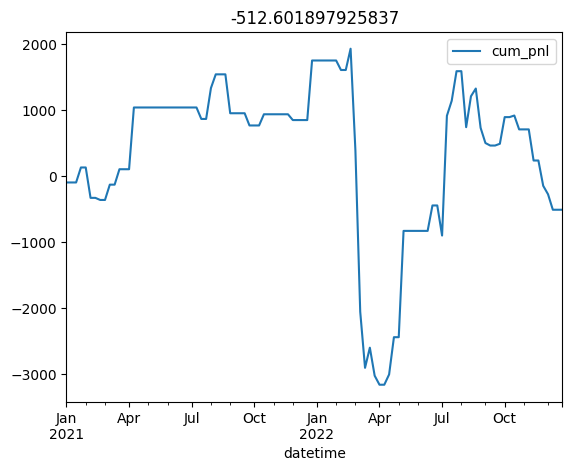

In [26]:
df_trades = pd.read_csv('./outputs/smabreakout00.csv')
df_trades['Date'] = pd.to_datetime(df_trades['Date'])
timezone = pytz.timezone('Etc/GMT+6')
sharpes = []
for day, df_day in df_trades.groupby(pd.Grouper(key='Date', freq='D')):
    if df_day.shape[0] == 0:
        continue
    df_day = df_day.copy()
    df_buy = df_day[df_day['Action'] == 'Buy']
    df_sell = df_day[df_day['Action'] == 'Sell']
    returns = df_sell['Price'].to_numpy() - df_buy['Price'].to_numpy()

    n_winning_trades = (returns > 0).astype(int).sum()
    n_losing_trades = len(returns) - n_winning_trades
    
    sharpe_ratio = np.mean(returns) / max(0.001, np.std(returns))
    sharpes.append({
        'datetime': day.tz_localize('US/Eastern'), 
        'n_trades': len(returns),
        'n_winning_trades': n_winning_trades,
        'n_losing_trades': n_losing_trades,
        'sharpe_ratio': sharpe_ratio,
    })

sharpes = pd.DataFrame(sharpes)
df_result = pd.merge(df_result, sharpes, how='left', on='datetime')
df_result['cum_pnl'] = df_result['pnl'].cumsum()
df_result.plot(x='datetime', y='cum_pnl', title=df_result['cum_pnl'].tolist()[-1])

In [27]:
print(
    f'Average: {df_result["pnl"].mean():.2f}  Sharpe Ratio: {df_result["sharpe_ratio"].mean():.2f}\n' \
    f'Wins: {(df_result["pnl"] > 0).sum()}  Avg: {df_result.loc[df_result["pnl"] > 0, "pnl"].mean():.2f}\n' \
    f'Losses: {(df_result["pnl"] < 0).sum()}  Avg: {df_result.loc[df_result["pnl"] < 0, "pnl"].mean():.2f}\n'
)

# Sharpe ratio is high due to the minimal amount of trades per day

Average: -4.93  Sharpe Ratio: 44.18
Wins: 22  Avg: 465.75
Losses: 23  Avg: -467.79

